In [1]:
%matplotlib inline
#%config InlineBackend.figure_formats = {'svg','png','png2x','retina','pdf'}
import numpy as np
import py_src.agent_based as ab
import sys

import matplotlib.pyplot as plt
import ipywidgets as wi

In [2]:
params = {
    # Hops:
    "hops_lynx": 2,
    "hops_lynx_eat": 2,
    "hops_hare": 1,
    # Probs:
    "prob_hare_hop": 1.0,
    "prob_hare_repr": 0.025,
    "prob_lynx_hop": 1.0,
    "prob_lynx_eat": 0.35,
    "prob_lynx_dead": 0.04,
    "prob_lynx_repr": 0.8,
}

In [3]:
model = ab.AgentModel(size=100,n_hares=100,n_lynxs=100,prs=params)
hares = []
lynxs = []
for t in range(1000):
    hares.append(model.hares.copy())
    lynxs.append(model.lynxs.copy())
    sys.stdout.write("\r%5d %5d %5d"%(t,np.sum(hares[-1]),np.sum(lynxs[-1])))
    sys.stdout.flush()
    res = model.step()
    if not res: break

  999   163    73

In [17]:
nhs = [np.sum(x) for x in hares]
nls = [np.sum(x) for x in lynxs]

def plot_time(t):
    img = np.ones((model.size,model.size,3))
    img[hares[t]>=1,:] = [0,0,1]
    img[lynxs[t]>=1,:] = [1,0,0]
    #
    f, axarr = plt.subplots(1,2,figsize=(12,6))
    axarr[0].set_title('Ubicación monines')
    axarr[0].imshow(img)
    axarr[1].set_title('Cantidad monines')
    axarr[1].plot(nhs,color="gray")
    axarr[1].plot(nls,color="gray")
    axarr[1].plot(nhs[:t+1],color="blue")
    axarr[1].plot(nls[:t+1],color="red")

interactive_plot = wi.interact(plot_time,t=wi.Play(min=0,max=len(hares)-1))
interactive_plot;

interactive(children=(Play(value=0, description='t', max=999), Output()), _dom_classes=('widget-interact',))

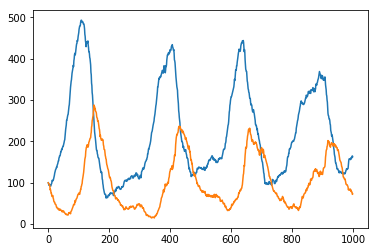

In [10]:
plt.plot(nhs)
plt.plot(nls)
plt.show()